# 3.6: 量子递归神经网络(QRNN)实现时序预测

## 时序预测
时序预测问题：考虑长度为 $\tilde{T}$ 的一段含时序列 ${x_t}$ $(t = 0,1,...,\tilde{T}-1)$，目标是已知长度为 $L$ 的一段序列 $(x_\tau, x_{\tau+1},...,x_{\tau+L-1})$ (其中 $\tau$ 的取值范围满足 $0 \leq \tau \leq \tilde{T}-L$)，预测下一时刻的取值 $x_{\tau+L}$

每个时刻的取值 $x_t$ 可以为一个数(标量)，例如单只股票的股价，也可以是多个值(向量)，例如多只股票的股价或物体运动的三维空间坐标等

### 测试集

时序预测任务的训练集、测试集定义：

* 数据集分割：前 $T$ 个时序构成训练集，剩余的数据构成测试集；
* 样本：第 $p$ 个样本定义为时序的切片 $x_{\tau:\tau+L-1}$（$L$ 为每个样本的长度，$\tau$ 的取值范围为 $0 \leq \tau \leq T-L-1$）

## QRNN

### Classical Recurrent Neural Network
![classical-rnn](./images/classical_rnn_architecture.png)

> 映射函数形式上可写为：$f(x_t,h_{t-1}|W) \rightarrow y_t,h_t$
>
>（其中$h_{t-1}$为隐藏层变量、$y_t$为输出、$W$为变分参数）
>
> 可取$x_{T+L} = y_{T+L-1}$作为预测结果。

### Quantum Recurrent Neural Network
![qrnn-architecture](./images/qrnn_architecture.png)

> $\hat{U}$ 可以是 AQDC 网络

**辅助量子位** (ancillary qubit): 其作用类似于RNN中的隐藏变量;

**特征量子位** (feature qubit): 用于将时序数据的信息传递给QRNN模型，并通过对该量子位的测量获得最终关于$x_{t+L}$预测。

#### 训练流程

![qrnn-process](./images/qrnn_process.png)

##### 信息读取、测量与后选择

计算特征量子位处于$|0\rangle$态的概率 $p_0 = \langle0|\hat{\rho}^{[0]}|0\rangle$

> 其中约化密度矩阵 $\hat{\rho}^{[0]} = \text{Tr}/0|\psi_i'\rangle\langle\psi_i'|$

根据需要，可在每次ADQC演化后读取信息（时序到时序的映射任务），也可在 L 次ADQC演化后读取（预测任务）

对特征量子位进行测量，通过后选择将其投影到$|0\rangle$，所得量子态满足

$|\gamma_l\rangle = \frac{1}{Z_l} N_a \langle0|\psi_l\rangle$

> 其中，归一化系数$Z_l = |N_a\langle0|\psi'_l\rangle|$

> 关于"后选择"
>
> * 在实际的量子计算过程中，由于测量结果是随机出现的，我们可以人为的保留"0"这个测量结果对应的量子态，以此实现投影操作。
>   * 量子计算中可以制备多个相同的量子态，RNN 每次（中间）测量的时候，特征量子位都可能出现 0 或者 1，那么要保留特征量子位为 0 的量子态，然后继续演化
>   * Seq-to-Seq 中，后选择有不同的做法
>
> * 在数值模拟上，不存在后选择操作，直接切片或计算投影即可

## Code

In [1]:
# |default_exp networks.qrnn
# |export
import torch

# useful devices
gpu = torch.device("mps")
cpu = torch.device("cpu")

### Network

In [2]:
# |export feature_mapping
from einops import einsum


def feature_map_to_qubit_state(features: torch.Tensor) -> torch.Tensor:
    assert features.ndim == 3 and features.shape[2] == 2, (
        f"feature must be a 3D tensor of shape (batch_size, feature_dim, 2), but got {features.shape}"
    )
    feature_num = features.shape[1]
    features = torch.split(features, 1, dim=1)  # tuple of tensors of shape (batch_size, 1, 2)
    features = [
        feature.squeeze(1) for feature in features
    ]  # list of tensors of shape (batch_size, 2)
    einsum_expression = "{features} -> {tensor}".format(
        features=",".join([f"batch f{i}" for i in range(feature_num)]),
        tensor=" ".join(["batch"] + [f"f{i}" for i in range(feature_num)]),
    )
    qubit_states = einsum(*features, einsum_expression)  # (batch_size, 2, ..., 2)
    return qubit_states

In [3]:
# |export
from typing import Literal
from tensor_network.networks.adqc import ADQCNet
from tensor_network.tensor_utils import zeros_state
from einops import einsum, rearrange
from torch import nn
from tensor_network.feature_mapping import cossin_feature_map, feature_map_to_qubit_state
import sys


class ADQCRNN(nn.Module):
    """
    ADQC-based QuantumRecurrent Neural Network

    The ADQCRNN processes sequential data by maintaining a quantum state across time steps.
    At each step, it encodes the input features into quantum states, combines them with
    the auxiliary qubits, and applies the ADQC network to update the state.
    """

    def __init__(
        self,
        *,
        num_aux_qubits: int,
        num_feature_qubits: int,
        num_layers: int,
        gate_pattern: Literal["brick", "stair"],
        identity_init: bool = False,
        double_precision: bool = False,
        feature_map: Literal["cossin"] = "cossin",
    ):
        """
        ADQC-based QuantumRecurrent Neural Network

        Args:
            num_aux_qubits: Number of auxiliary qubits in the ADQC network
            num_feature_qubits: Number of feature qubits (should match the feature dimension of input data)
            num_layers: Number of layers in the ADQC network
            gate_pattern: Pattern of gate connections, either "brick" or "stair"
            identity_init: Whether to initialize gates close to identity matrices
            double_precision: Whether to use double precision (complex128) or single precision (complex64)
            feature_map: Type of feature map to use for encoding classical data into quantum states
                         Currently only "cossin" is implemented

        """
        super().__init__()
        assert num_aux_qubits > 0
        assert num_feature_qubits > 0
        assert num_layers > 0
        assert gate_pattern in ["brick", "stair"]
        self.num_aux_qubits = num_aux_qubits
        self.num_feature_qubits = num_feature_qubits
        self.net = ADQCNet(
            num_qubits=num_aux_qubits + num_feature_qubits,
            num_layers=num_layers,
            gate_pattern=gate_pattern,
            identity_init=identity_init,
            double_precision=double_precision,
        )
        self.complex_dtype = torch.complex128 if double_precision else torch.complex64
        if feature_map == "cossin":
            self.feature_map = cossin_feature_map
            self.feature_map_compiled = torch.compile(self.feature_map)
        else:
            raise Exception(f"The only implemented feature map is cossin, but got {feature_map}")

    def forward(self, data_batch: torch.Tensor) -> torch.Tensor:
        # data_batch shape: (batch_size, sample_length, feature_dim)
        assert len(data_batch.shape) == 3, (
            f"data_batch must be a 3D tensor of shape (batch_size, sample_length, feature_dim), but got {len(data_batch.shape)}"
        )
        batch_size, sample_length, feature_dim = data_batch.shape
        device = data_batch.device
        is_mps = device.type == "mps"
        assert feature_dim == self.num_feature_qubits, (
            f"feature_dim must be equal to the number of feature qubits, but got {feature_dim=} and {self.num_feature_qubits=}"
        )

        aux_qubit_states = zeros_state(num_qubits=self.num_aux_qubits, dtype=self.complex_dtype).to(
            device
        )  # (*aux_qubit_dims)
        aux_qubit_states = torch.stack(
            [aux_qubit_states] * batch_size, dim=0
        )  # (batch_size, *aux_qubit_dims)
        aux_qubit_states_shape = aux_qubit_states.shape
        batch_dim_name = "batch"
        aux_qubit_names = [f"a{i}" for i in range(self.num_aux_qubits)]
        feature_qubit_names = [f"f{i}" for i in range(self.num_feature_qubits)]
        qubit_cross_product_expression = "{aux_dims}, {feature_dims} -> {state_dims}".format(
            aux_dims=" ".join([batch_dim_name] + aux_qubit_names),
            feature_dims=" ".join([batch_dim_name] + feature_qubit_names),
            state_dims=" ".join([batch_dim_name] + aux_qubit_names + feature_qubit_names),
        )
        projected_feature_state = [0] * self.num_feature_qubits

        for t in range(sample_length):
            if is_mps:
                features = self.feature_map(data_batch[:, t, :])  # (batch_size, feature_dim, 2)
            else:
                features = self.feature_map_compiled(
                    data_batch[:, t, :]
                )  # (batch_size, feature_dim, 2)

            feature_qubit_states = feature_map_to_qubit_state(
                features
            )  # (batch_size, *feature_qubit_dims)

            states = einsum(
                aux_qubit_states, feature_qubit_states, qubit_cross_product_expression
            )  # (batch_size, *aux_qubit_dims, *feature_qubit_dims)
            states = self.net(states)  # (batch_size, *aux_qubit_dims, *feature_qubit_dims)
            states = rearrange(
                states,
                "batch {aux_dims} {feature_dims} -> {feature_dims} batch {aux_dims} ".format(
                    aux_dims=" ".join(aux_qubit_names),
                    feature_dims=" ".join(feature_qubit_names),
                ),
            )  # (*feature_qubit_dims, batch_size, *aux_qubit_dims)
            # projection
            projected_aux_qubit_states = states[
                *projected_feature_state
            ]  # (batch_size, *aux_qubit_dims)
            projected_aux_qubit_states = projected_aux_qubit_states.reshape(
                batch_size, -1
            )  # (batch_size, 2**num_aux_qubits)
            if is_mps:
                # see https://github.com/pytorch/pytorch/issues/146691
                norms = (
                    (projected_aux_qubit_states * projected_aux_qubit_states.conj())
                    .real.sum(dim=1, keepdim=True)
                    .sqrt()
                )  # (batch_size, 1)
            else:
                norms = projected_aux_qubit_states.norm(dim=1, keepdim=True)  # (batch_size, 1)
            projected_aux_qubit_states = (
                projected_aux_qubit_states / norms
            )  # (batch_size, 2**num_aux_qubits)
            # finished one step and set the aux_qubit_states for the next step
            aux_qubit_states = projected_aux_qubit_states.reshape(
                aux_qubit_states_shape
            )  # (batch_size, *aux_qubit_dims)

        # the norm of the projected_aux_qubit_states is the probability of the projected feature state
        prob_of_projected_feature_state = norms.squeeze(1)  # (batch_size,)
        return prob_of_projected_feature_state

### Hyperparameters

In [4]:
# data parameters
series_length = 500
order = 8
train_ratio = 0.8
train_data_num = int(train_ratio * series_length)
sample_length = 4


# network parameters
num_aux_qubits = 4
num_feature_qubits = 1
num_layers = 4
gate_pattern = "brick"
identity_init = False
double_precision = False

# training parameters
default_device = cpu
batch_size = 100
epochs = 1000
lr = 1e-3

### Data Preparation

In [5]:
from matplotlib import pyplot as plt
from tensor_network.tensor_utils import normalize_tensor
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# |export
def series_sin_cos(
    length: int, coeff_sin: torch.Tensor, coeff_cos: torch.Tensor, k_step: float = 0.02
) -> torch.Tensor:
    assert coeff_sin.ndim == 1 and coeff_cos.ndim == 1
    assert coeff_sin.numel() == coeff_cos.numel()
    assert coeff_sin.device == coeff_cos.device
    order = coeff_sin.numel()
    device = coeff_sin.device
    time_steps = torch.arange(length, device=device)  # (length,)
    time_steps = time_steps.unsqueeze(0)  # (1, length)
    coeff_sin = coeff_sin.unsqueeze(1)  # (order, 1)
    coeff_cos = coeff_cos.unsqueeze(1)  # (order, 1)
    orders = torch.arange(order, device=device).unsqueeze(1)  # (order, 1)
    y_sin = torch.sin(time_steps * (orders * k_step)) * coeff_sin  # (order, length)
    y_sin = y_sin.sum(dim=0)  # (length,)
    y_cos = torch.cos(time_steps * (orders * k_step)) * coeff_cos  # (order, length)
    y_cos = y_cos.sum(dim=0)  # (length,)
    series = y_sin + y_cos  # (length,)
    return series

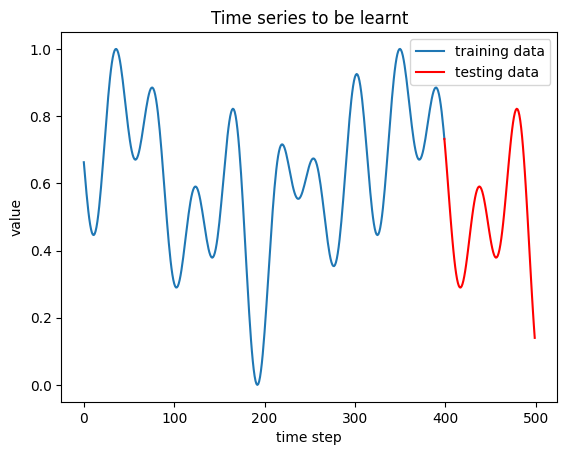

In [7]:
coeff_sin = torch.randn(order, device=gpu)
coeff_cos = torch.randn(order, device=gpu)
series = series_sin_cos(series_length, coeff_sin, coeff_cos)
series = normalize_tensor(series).to(default_device)

train_series = series[:train_data_num]
test_series = series[train_data_num:]

# Visualize the training and testing data

train_indices = list(range(train_data_num))
test_indices = list(range(train_data_num - 1, series_length, 1))

plt.plot(train_indices, series[:train_data_num].cpu(), label="training data")
plt.plot(test_indices, series[train_data_num - 1 :].cpu(), color="r", label="testing data")
plt.legend()
plt.xlabel("time step")
plt.ylabel("value")
plt.title("Time series to be learnt")
plt.show()

In [8]:
# |export
def prepare_series_samples(
    series: torch.Tensor, sample_length: int, step_size: int
) -> torch.Tensor:
    assert sample_length >= step_size >= 1
    length = series.shape[0]
    assert length >= sample_length
    samples = []
    for start in range(0, length - sample_length, step_size):
        sample = series[start : start + sample_length]
        samples.append(sample)

    return torch.stack(samples, dim=0)

In [9]:
train_samples = prepare_series_samples(train_series, sample_length + 1, 2)
train_data = train_samples[:, :sample_length]  # (num_samples, sample_length)
train_targets = train_samples[:, sample_length]  # (num_samples,)
train_loader = DataLoader(
    TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True
)

test_samples = prepare_series_samples(test_series, sample_length + 1, 1)
test_data = test_samples[:, :sample_length]  # (num_samples, sample_length)
test_targets = test_samples[:, sample_length]  # (num_samples,)
test_loader = DataLoader(
    TensorDataset(test_data, test_targets), batch_size=batch_size, shuffle=False
)

### Training

In [10]:
from torch.optim import Adam
from tqdm.auto import tqdm

In [11]:
qrnn_net = ADQCRNN(
    num_aux_qubits=num_aux_qubits,
    num_feature_qubits=num_feature_qubits,
    num_layers=num_layers,
    gate_pattern=gate_pattern,
    identity_init=identity_init,
    double_precision=double_precision,
).to(default_device)

optimizer = Adam(qrnn_net.parameters(), lr=lr)
loss = nn.MSELoss()

In [12]:
training_losses = torch.empty(epochs, device=cpu)

for epoch in tqdm(range(epochs)):
    epoch_loss = 0.0
    for samples, targets in train_loader:
        # because the feature_dim is 1
        samples = samples.to(default_device).unsqueeze(-1)  # (batch_size, sample_length, 1)
        targets = targets.to(default_device)
        norms = qrnn_net(samples)
        loss_batch = loss(norms, targets)
        epoch_loss += loss_batch.detach().cpu() * samples.shape[0]
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
    training_losses[epoch] = epoch_loss / train_data_num

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
test_loss = 0.0
with torch.no_grad():
    for samples, targets in test_loader:
        samples = samples.to(default_device).unsqueeze(-1)
        targets = targets.to(default_device)
        norms = qrnn_net(samples)
        loss_batch = loss(norms, targets)
        test_loss += loss_batch.detach().cpu() * samples.shape[0]
test_loss /= series_length - train_data_num

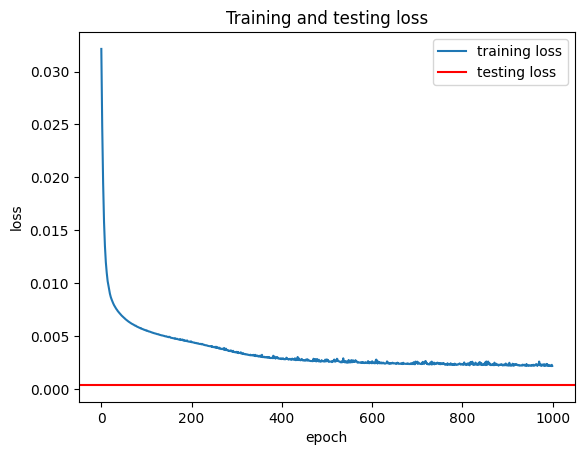

In [14]:
plt.plot(training_losses, label="training loss")
# plot test loss as a horizontal line
plt.axhline(test_loss, color="r", label="testing loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and testing loss")
plt.show()

In [15]:
# TODO: plot the predicted results by plotting the predicted curve
# TODO: use ADQC to predict the time series